In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Libraries to define the required functions
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from pmdarima.model_selection import train_test_split as time_train_test_split
from sklearn import metrics
from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [4]:
df=pd.read_csv('Australia Renewable data.csv')
weather_data=pd.read_csv('Australia Weather Data.csv')

weather_data.head()

,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity
0,01-01-2010,38.6,5.6,22.7,5.0,36.1,7.81,40.7,181.41,59.4,13.1,34.1,52.03
1,01-02-2010,33.0,9.9,20.6,9.4,32.2,205.15,37.1,151.96,51.8,12.2,50.6,65.61
2,01-03-2010,28.1,6.9,17.6,6.3,27.6,112.28,34.2,168.56,51.8,11.8,41.0,70.08
3,01-04-2010,25.1,0.8,13.9,-0.5,0.0,23.71,46.4,202.99,51.8,12.5,37.5,71.73
4,01-05-2010,21.6,-2.9,9.0,-4.8,0.0,77.97,35.3,173.52,46.4,11.9,47.6,77.42


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Time                                        145 non-null    object 
 1   Coal, Peat and Manufactured Gases           145 non-null    float64
 2   Combustible Renewables                      145 non-null    float64
 3   Geothermal                                  145 non-null    int64  
 4   Hydro                                       145 non-null    float64
 5   Natural Gas                                 145 non-null    float64
 6   Not Specified                               145 non-null    int64  
 7   Nuclear                                     145 non-null    int64  
 8   Oil and Petroleum Products                  145 non-null    float64
 9   Other Combustible Non-Renewables            145 non-null    int64  
 10  Other Renewabl

In [5]:
df["Time"]=pd.to_datetime(df['Time'])
df['Time']=df['Time'].dt.strftime('%Y-%d-%m')
df["Time"]=pd.to_datetime(df['Time'])
df.head()

,Time,"Coal, Peat and Manufactured Gases",Combustible Renewables,Geothermal,Hydro,Natural Gas,Not Specified,Nuclear,Oil and Petroleum Products,Other Combustible Non-Renewables,Other Renewables,Solar,Wind,Total Combustible Fuels,"Total Renewables (Geo, Solar, Wind, Other)"
0,2010-01-01,0.050489,0.000738,0,0.003381,0.012094,0,0,0.002499,0,0,0.000168,0.001397,0.065819,0.001565
1,2010-02-01,0.046005,0.000738,0,0.003356,0.012367,0,0,0.001370,0,0,0.000133,0.001331,0.060480,0.001464
2,2010-03-01,0.049576,0.000738,0,0.002910,0.011377,0,0,0.000300,0,0,0.000127,0.001418,0.061991,0.001546
3,2010-04-01,0.044356,0.000738,0,0.003564,0.011577,0,0,0.000200,0,0,0.000091,0.001196,0.056871,0.001288
4,2010-05-01,0.047164,0.000738,0,0.004500,0.013251,0,0,0.000814,0,0,0.000067,0.001013,0.061967,0.001080


In [6]:
weather_data["Date time"]=pd.to_datetime(weather_data['Date time'])

weather_data['Date time']=weather_data['Date time'].dt.strftime('%Y-%d-%m')
weather_data["Date time"]=pd.to_datetime(weather_data['Date time'])
weather_data.head()

,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity
0,2010-01-01,38.6,5.6,22.7,5.0,36.1,7.81,40.7,181.41,59.4,13.1,34.1,52.03
1,2010-02-01,33.0,9.9,20.6,9.4,32.2,205.15,37.1,151.96,51.8,12.2,50.6,65.61
2,2010-03-01,28.1,6.9,17.6,6.3,27.6,112.28,34.2,168.56,51.8,11.8,41.0,70.08
3,2010-04-01,25.1,0.8,13.9,-0.5,0.0,23.71,46.4,202.99,51.8,12.5,37.5,71.73
4,2010-05-01,21.6,-2.9,9.0,-4.8,0.0,77.97,35.3,173.52,46.4,11.9,47.6,77.42


In [7]:
weather_data.rename(columns={'Date time':'Time'},inplace=True)

In [8]:
final_prod=df.merge(weather_data, on='Time')
# final_prod=final_prod.drop(['Heat Index'],axis=1)
final_prod=final_prod.fillna(0)
actual_US=final_prod.copy()
final_prod

,Time,"Coal, Peat and Manufactured Gases",Combustible Renewables,Geothermal,Hydro,Natural Gas,Not Specified,Nuclear,Oil and Petroleum Products,Other Combustible Non-Renewables,...,Temperature,Wind Chill,Heat Index,Precipitation,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity
0,2010-01-01,0.050489,0.000738,0,0.003381,0.012094,0,0,0.002499,0,...,22.7,5.0,36.1,7.81,40.7,181.41,59.4,13.1,34.1,52.03
1,2010-02-01,0.046005,0.000738,0,0.003356,0.012367,0,0,0.001370,0,...,20.6,9.4,32.2,205.15,37.1,151.96,51.8,12.2,50.6,65.61
2,2010-03-01,0.049576,0.000738,0,0.002910,0.011377,0,0,0.000300,0,...,17.6,6.3,27.6,112.28,34.2,168.56,51.8,11.8,41.0,70.08
3,2010-04-01,0.044356,0.000738,0,0.003564,0.011577,0,0,0.000200,0,...,13.9,-0.5,0.0,23.71,46.4,202.99,51.8,12.5,37.5,71.73
4,2010-05-01,0.047164,0.000738,0,0.004500,0.013251,0,0,0.000814,0,...,9.0,-4.8,0.0,77.97,35.3,173.52,46.4,11.9,47.6,77.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2021-09-01,0.032992,0.000817,0,0.004644,0.008862,0,0,0.002654,0,...,9.6,-5.2,0.0,45.32,40.7,228.27,59.4,9.5,25.0,71.72
141,2021-10-01,0.033516,0.000823,0,0.004674,0.008263,0,0,0.003048,0,...,12.3,-0.9,0.0,68.15,40.5,207.04,50.0,9.8,34.2,73.54
142,2021-11-01,0.033240,0.000790,0,0.004679,0.007849,0,0,0.003183,0,...,14.1,-0.2,0.0,139.84,44.7,200.14,64.8,9.7,43.9,75.97
143,2021-12-01,0.035250,0.000821,0,0.003785,0.008842,0,0,0.003169,0,...,17.3,4.7,29.2,89.38,42.4,172.63,64.8,9.9,34.7,71.47


In [9]:
final_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 144
Data columns (total 27 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Time                                        145 non-null    datetime64[ns]
 1   Coal, Peat and Manufactured Gases           145 non-null    float64       
 2   Combustible Renewables                      145 non-null    float64       
 3   Geothermal                                  145 non-null    int64         
 4   Hydro                                       145 non-null    float64       
 5   Natural Gas                                 145 non-null    float64       
 6   Not Specified                               145 non-null    int64         
 7   Nuclear                                     145 non-null    int64         
 8   Oil and Petroleum Products                  145 non-null    float64       
 9   Other Comb

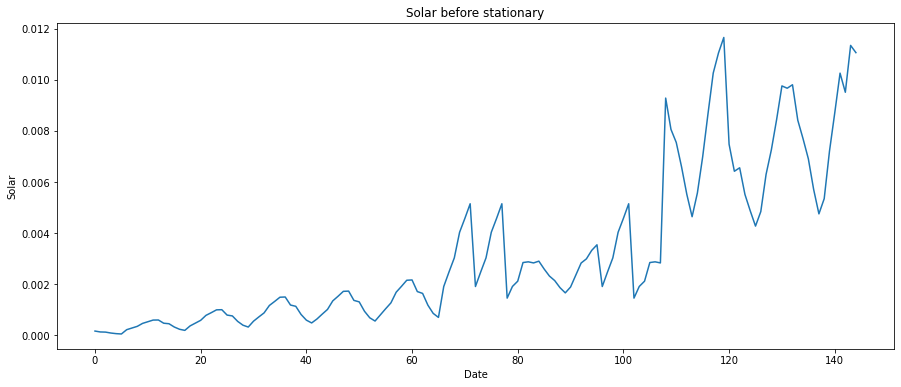

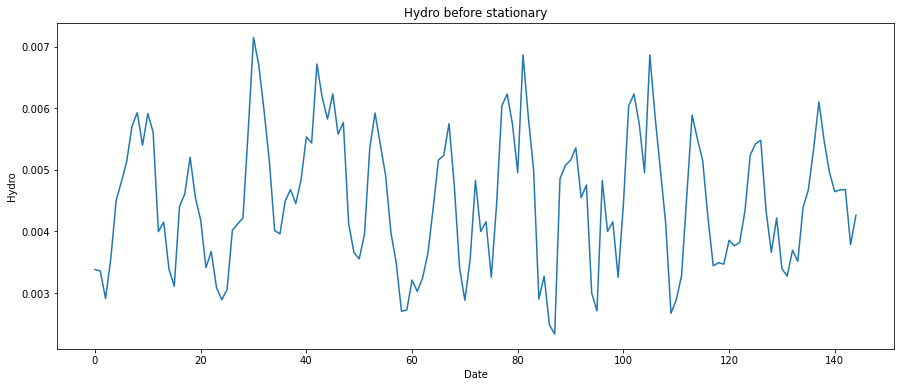

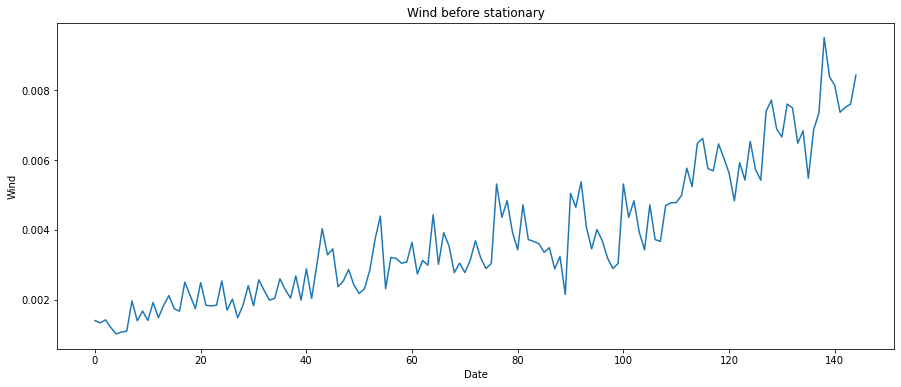

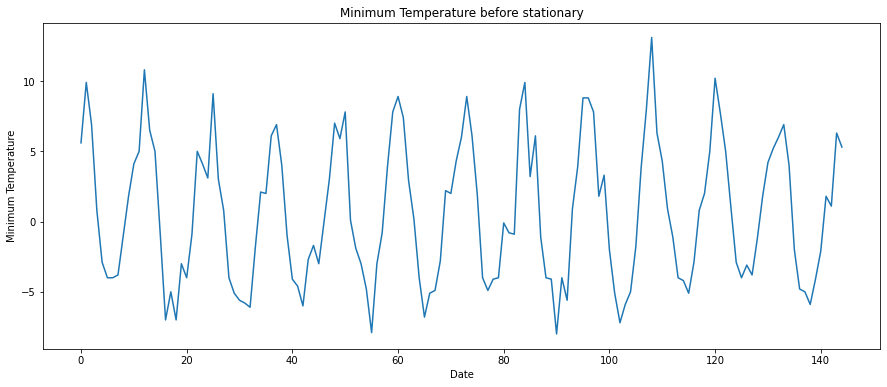

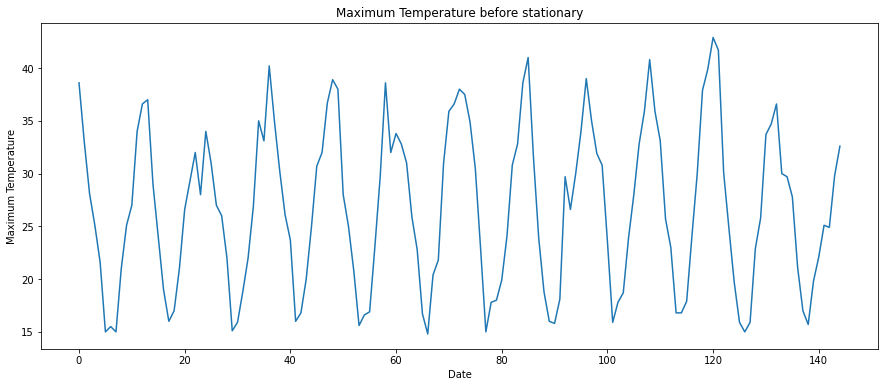

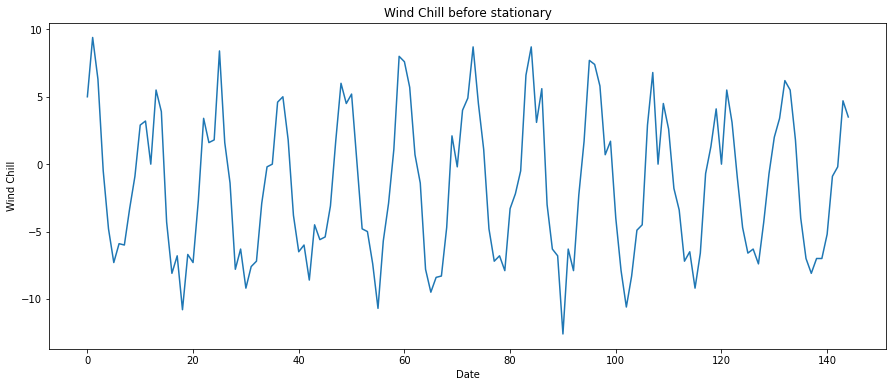

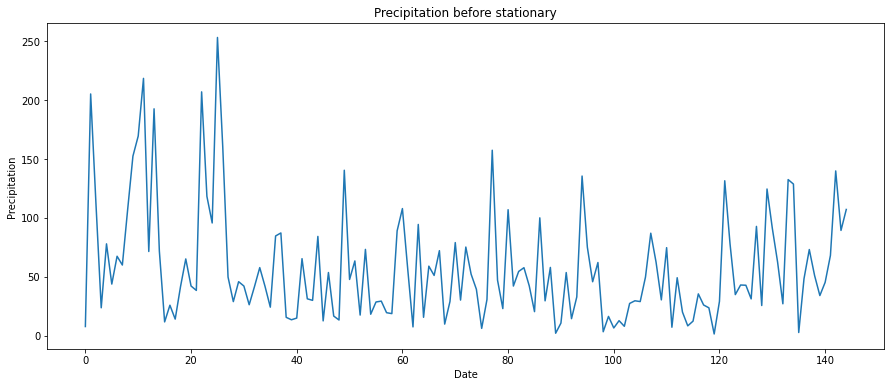

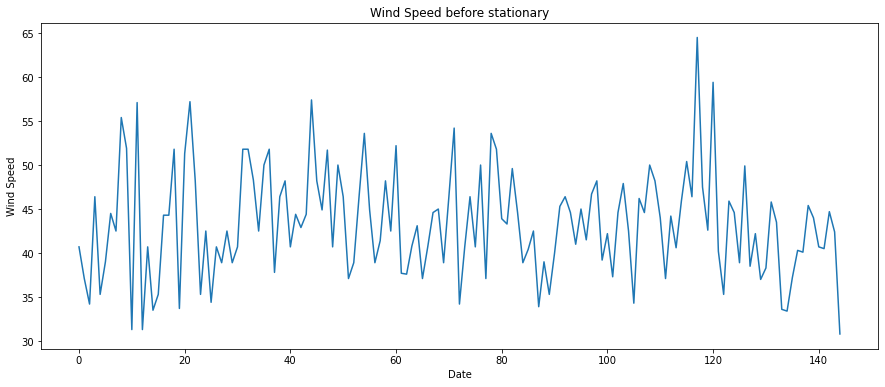

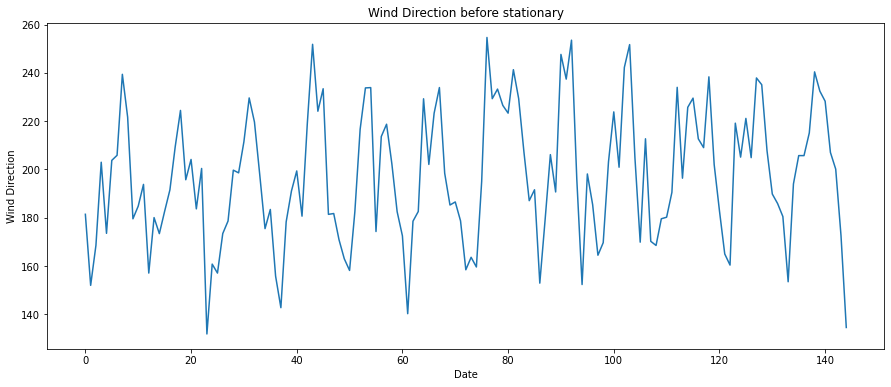

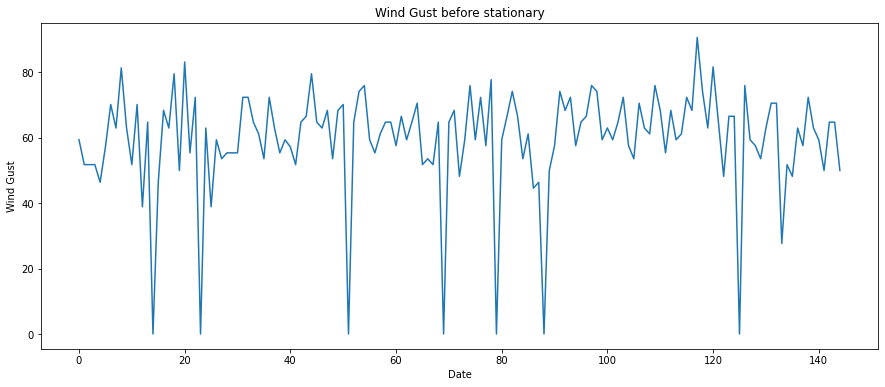

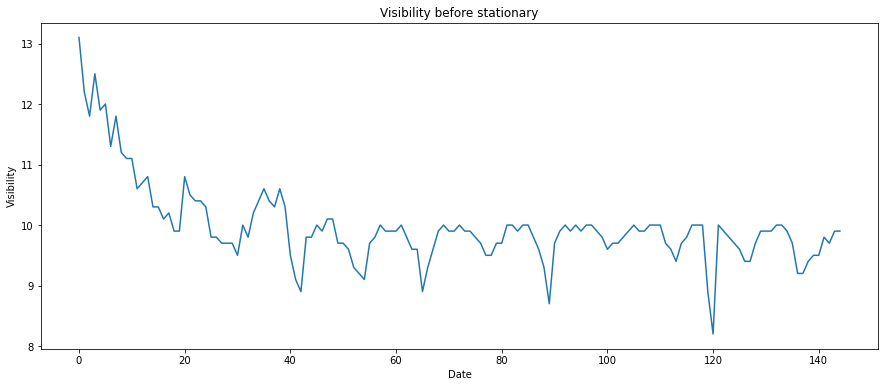

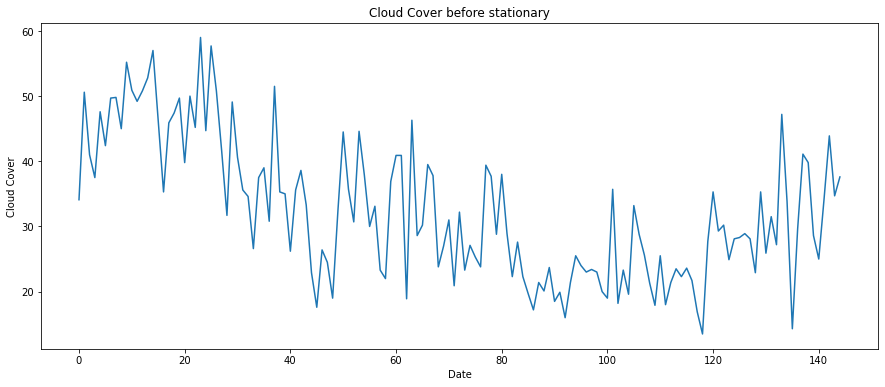

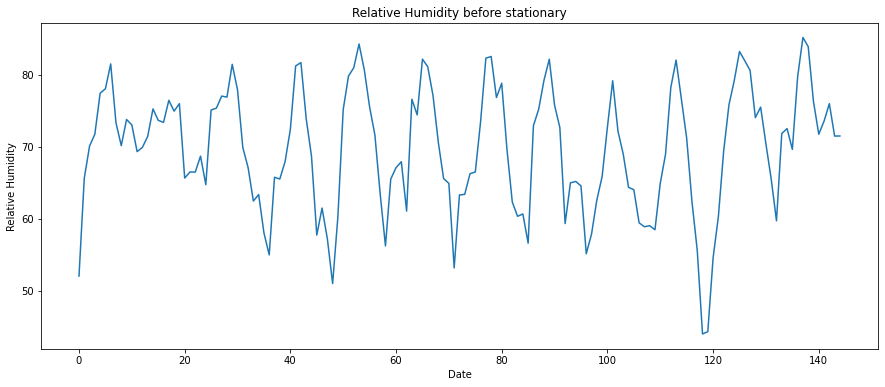

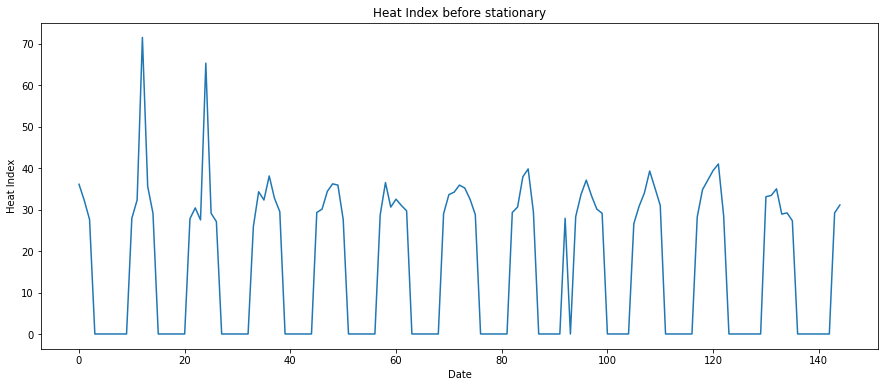

In [10]:
for feature in final_prod[['Solar','Hydro','Wind','Minimum Temperature','Maximum Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Wind Gust','Visibility','Cloud Cover','Relative Humidity','Heat Index']]:
    final_prod[str(feature)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)} before stationary")
    plt.show()

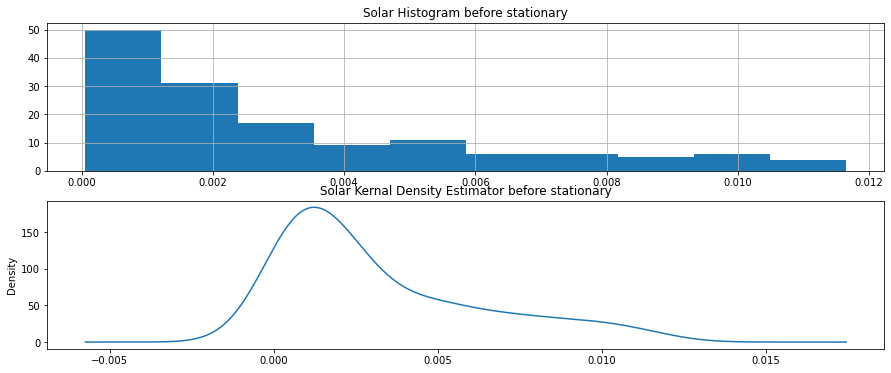

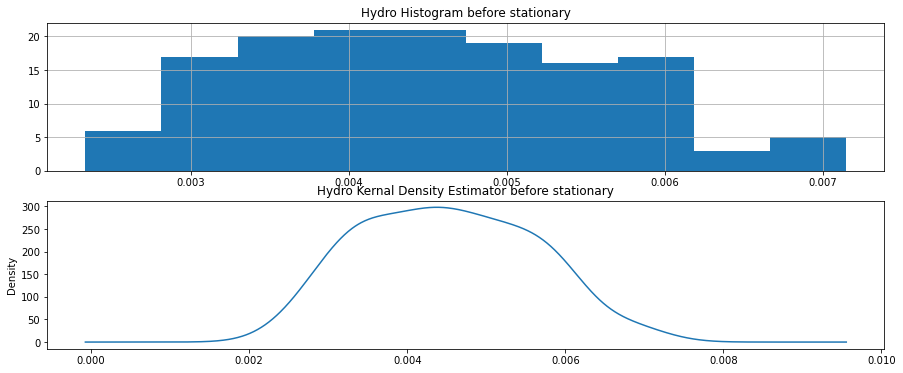

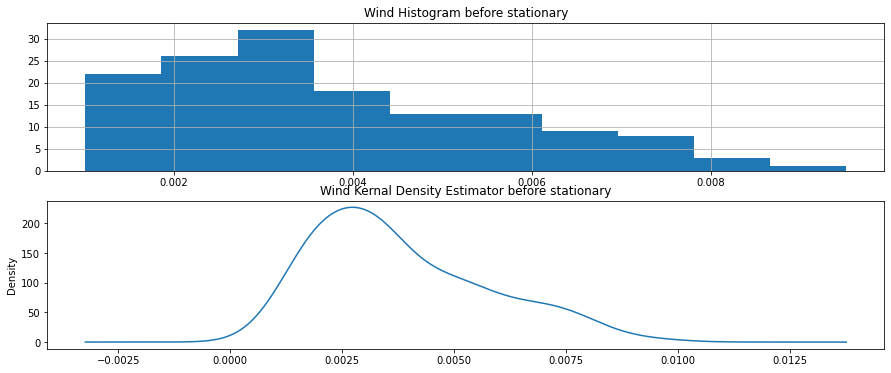

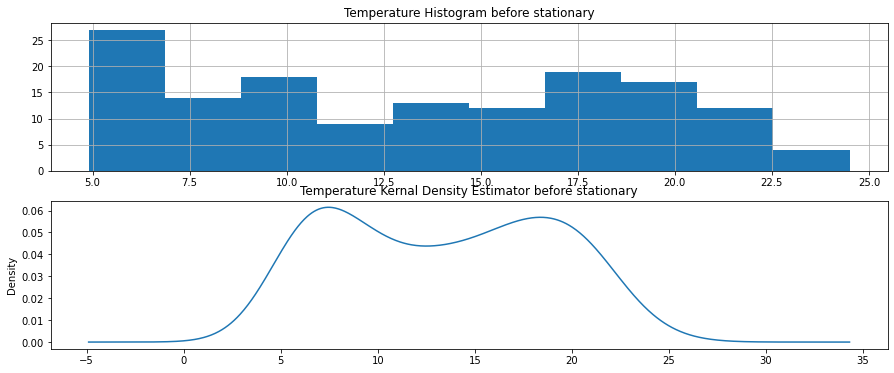

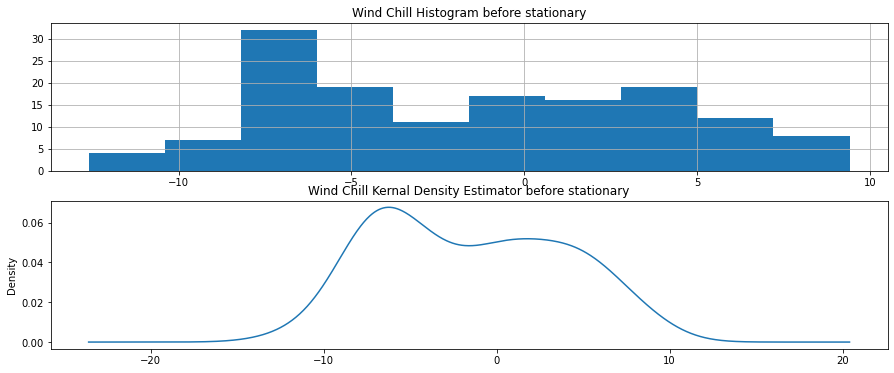

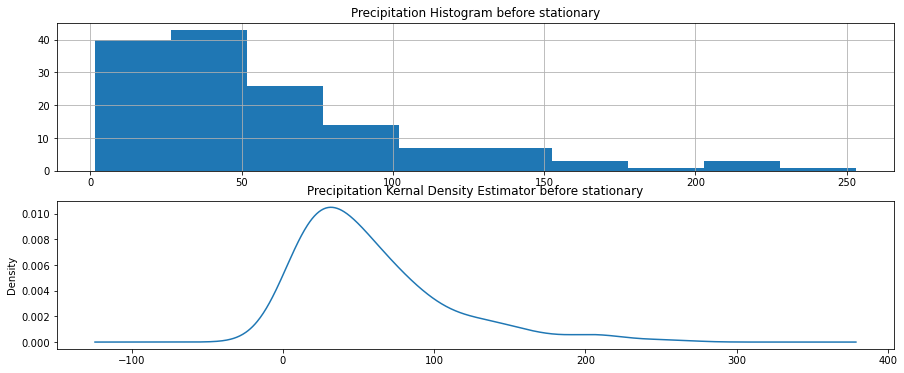

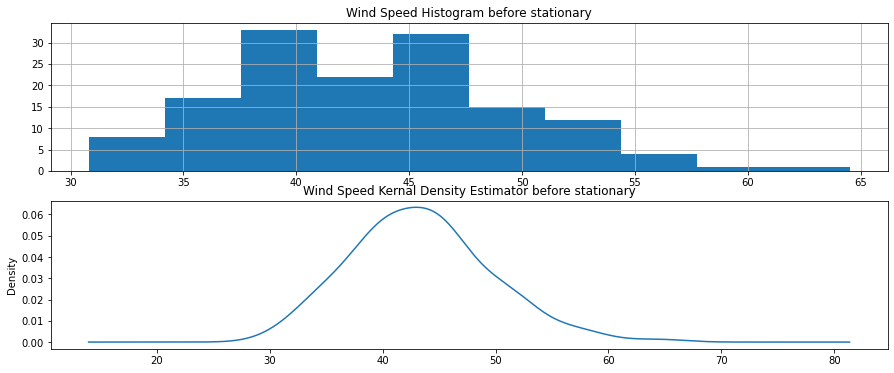

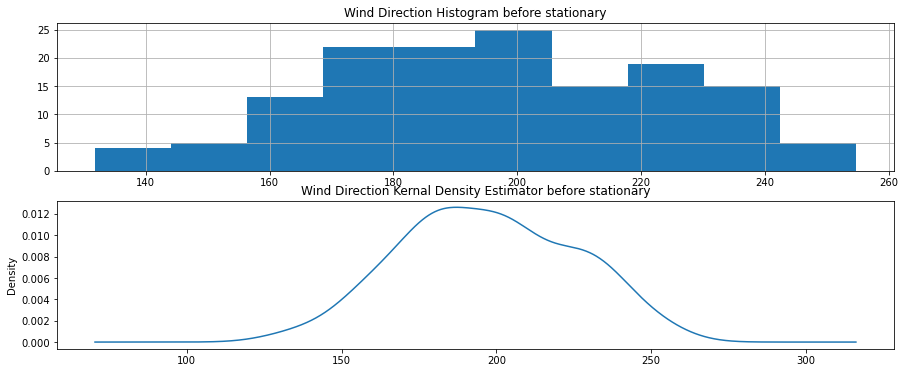

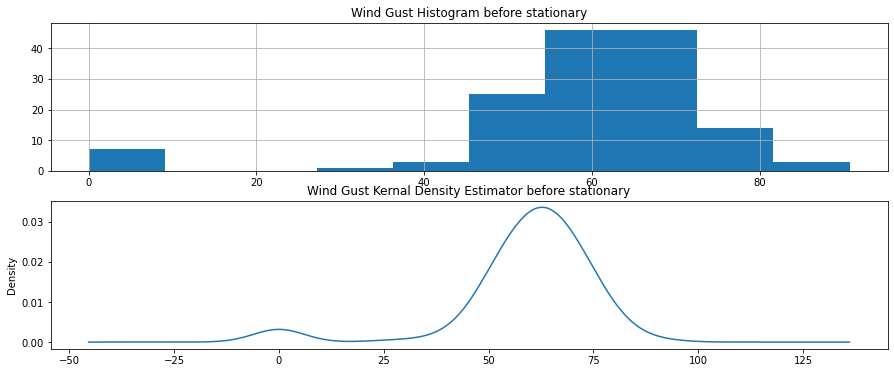

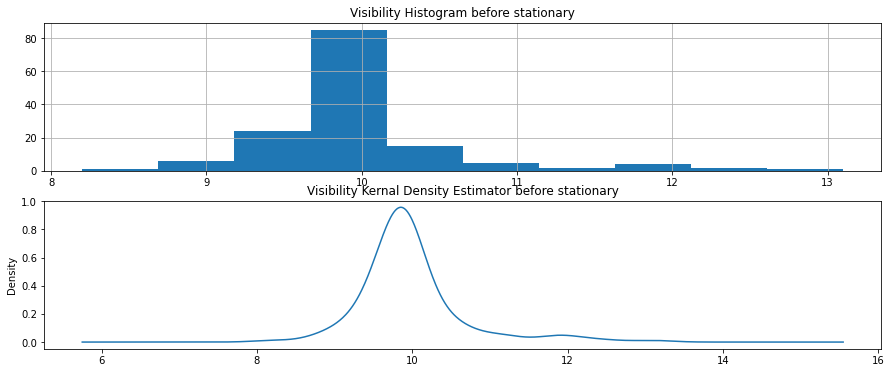

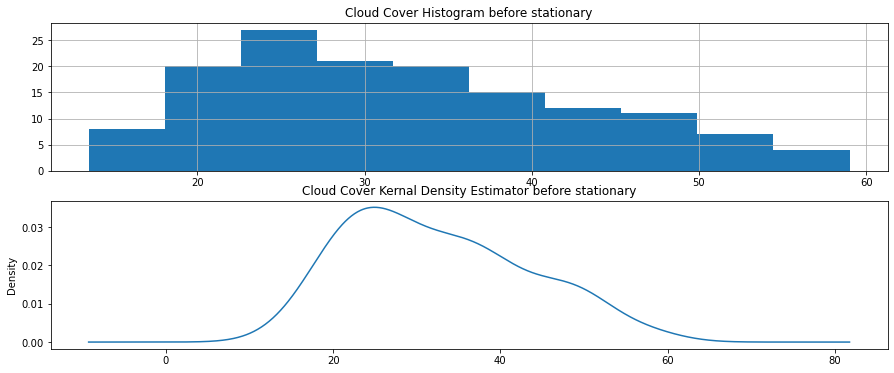

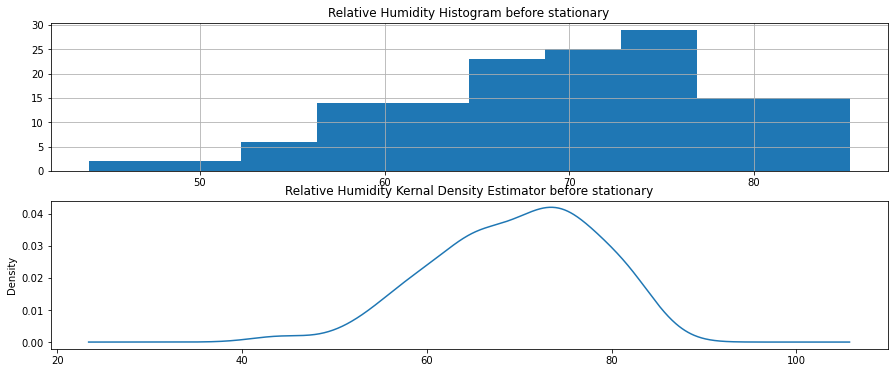

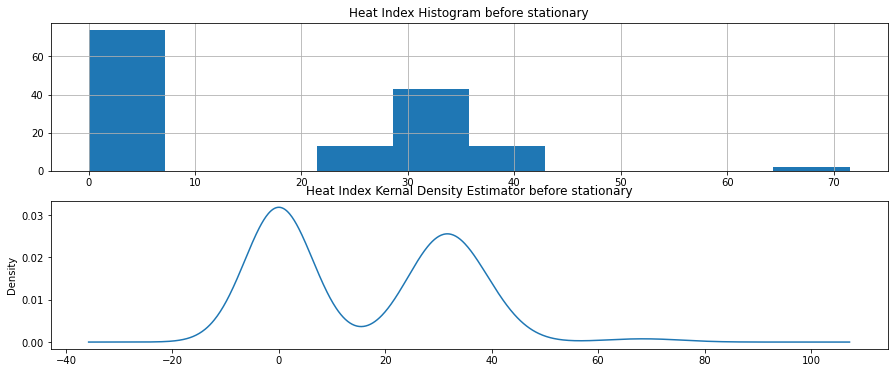

In [11]:
for feature in final_prod[['Solar','Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Wind Gust','Visibility','Cloud Cover','Relative Humidity','Heat Index']]:
    plt.figure(1, figsize=(15,6))
    plt.subplot(211)
    plt.title(f"{str(feature)} Histogram before stationary")
    final_prod[str(feature)].hist()
    plt.subplot(212)
    final_prod[str(feature)].plot(kind='kde')
    plt.title(f"{str(feature)} Kernal Density Estimator before stationary")
    plt.show()

In [12]:
def mean_absolute_percentage_error(y_true, y_pred):   
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [14]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [15]:
def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [16]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [17]:
x=final_prod[['Solar',  'Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Wind Gust','Visibility','Cloud Cover','Relative Humidity','Heat Index']]

trainX,testX=time_train_test_split(x,test_size=0.3)


In [18]:
trainX

,Solar,Hydro,Wind,Temperature,Wind Chill,Precipitation,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Heat Index
0,0.000168,0.003381,0.001397,22.7,5.0,7.81,40.7,181.41,59.4,13.1,34.1,52.03,36.1
1,0.000133,0.003356,0.001331,20.6,9.4,205.15,37.1,151.96,51.8,12.2,50.6,65.61,32.2
2,0.000127,0.002910,0.001418,17.6,6.3,112.28,34.2,168.56,51.8,11.8,41.0,70.08,27.6
3,0.000091,0.003564,0.001196,13.9,-0.5,23.71,46.4,202.99,51.8,12.5,37.5,71.73,0.0
4,0.000067,0.004500,0.001013,9.0,-4.8,77.97,35.3,173.52,46.4,11.9,47.6,77.42,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.001911,0.004827,0.003685,22.4,7.4,45.82,41.5,185.42,66.6,10.0,23.0,55.13,37.1
97,0.002483,0.003998,0.003189,20.4,5.8,62.13,46.7,164.45,76.0,10.0,23.4,57.87,33.3
98,0.003032,0.004156,0.002889,17.8,0.7,3.39,48.2,169.65,74.2,9.9,23.0,62.59,30.1
99,0.004034,0.003255,0.003035,16.0,1.7,16.40,39.2,203.15,59.4,9.8,20.0,65.84,29.1


In [19]:
for name, column in final_prod[['Solar','Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Visibility','Cloud Cover','Relative Humidity','Heat Index']].iteritems():
    Augmented_Dickey_Fuller_Test_func(final_prod[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Solar
Test Statistic                   0.722169
p-value                          0.990270
No Lags Used                    12.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Hydro
Test Statistic                  -4.864024
p-value                          0.000041
No Lags Used                     6.000000
Number of Observations Used    138.000000
Critical Value (1%)             -3.478648
Critical Value (5%)             -2.882722
Critical Value (10%)            -2.578065
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Wind
Test Statistic                   1.592010
p-value                          0.997833
No Lags Used 

In [20]:
train_diff = trainX.diff()
train_diff.dropna(inplace = True)

In [21]:
for name, column in final_prod[['Solar','Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Visibility','Cloud Cover','Relative Humidity','Heat Index']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Solar
Test Statistic                -7.186562e+00
p-value                        2.567765e-10
No Lags Used                   4.000000e+00
Number of Observations Used    9.500000e+01
Critical Value (1%)           -3.501137e+00
Critical Value (5%)           -2.892480e+00
Critical Value (10%)          -2.583275e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Hydro
Test Statistic                -6.378442e+00
p-value                        2.253295e-08
No Lags Used                   8.000000e+00
Number of Observations Used    9.100000e+01
Critical Value (1%)           -3.504343e+00
Critical Value (5%)           -2.893866e+00
Critical Value (10%)          -2.584015e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Wind
Test Statistic                 -5.431320
p-value                         0.000003

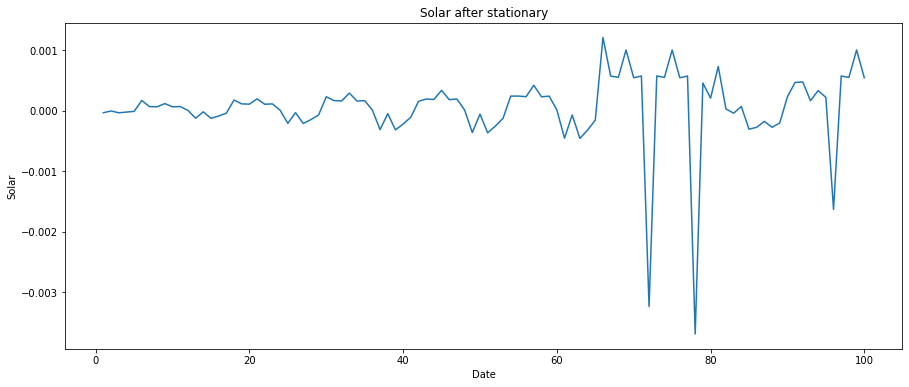

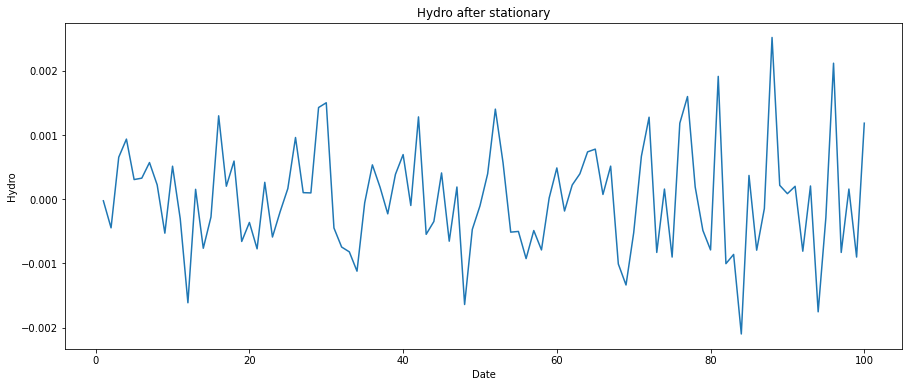

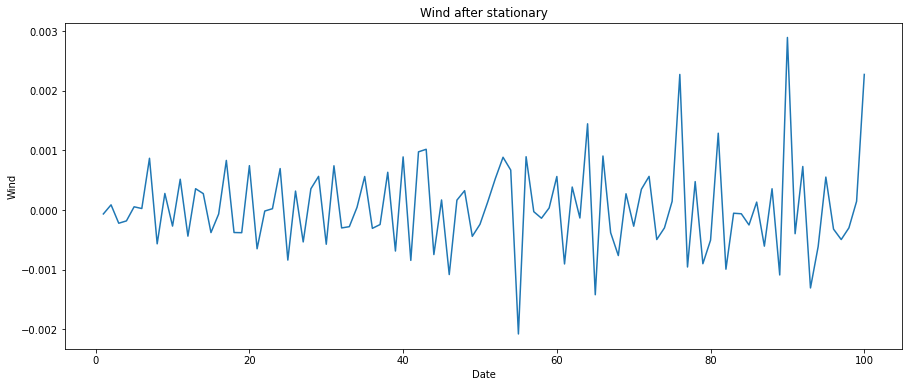

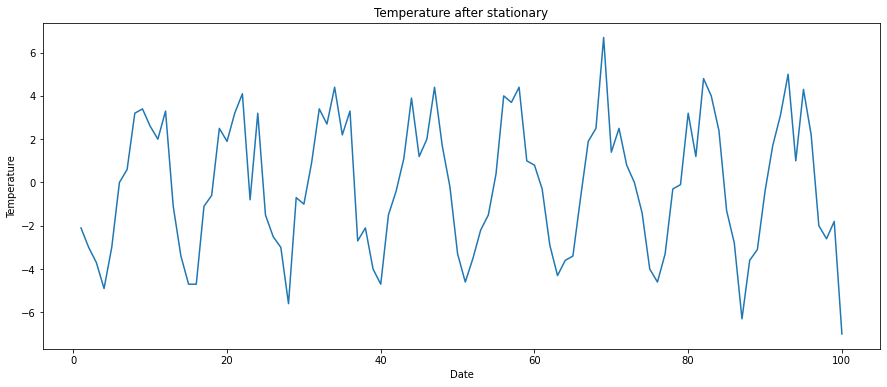

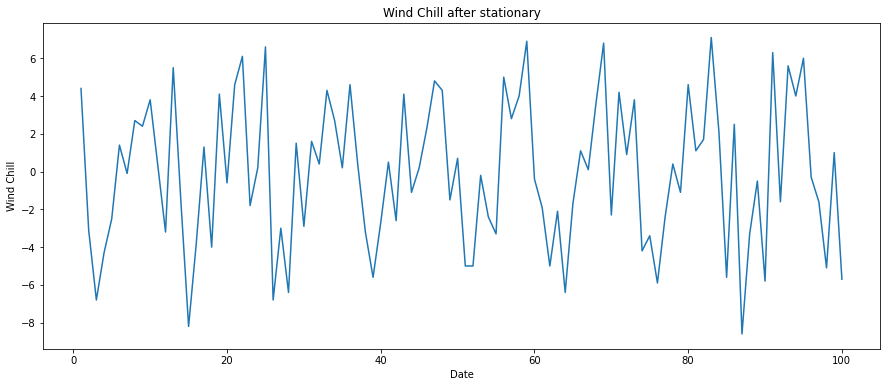

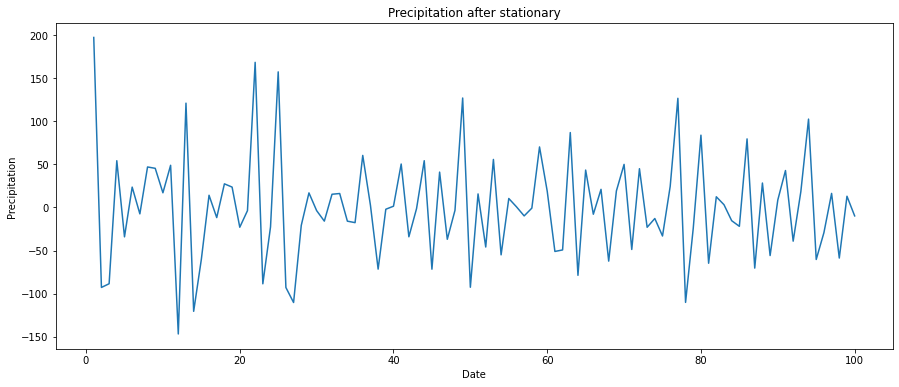

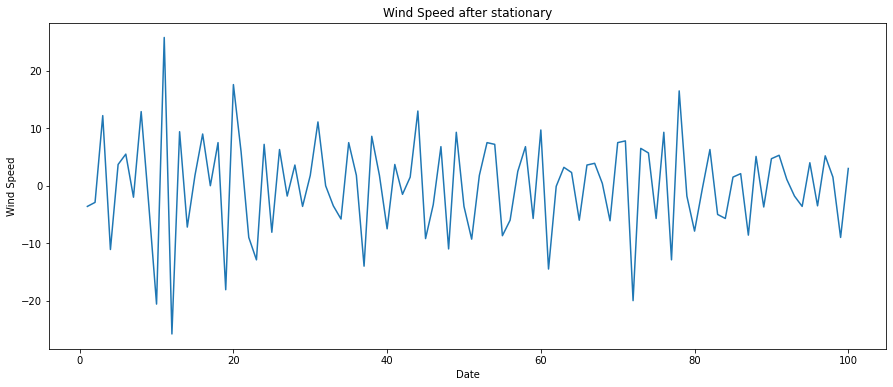

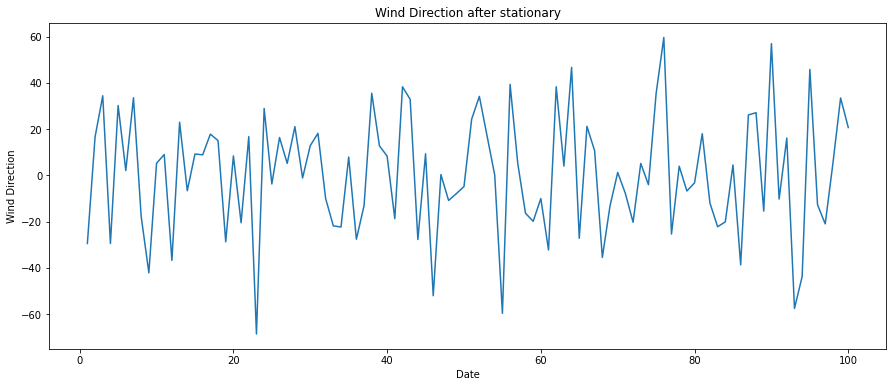

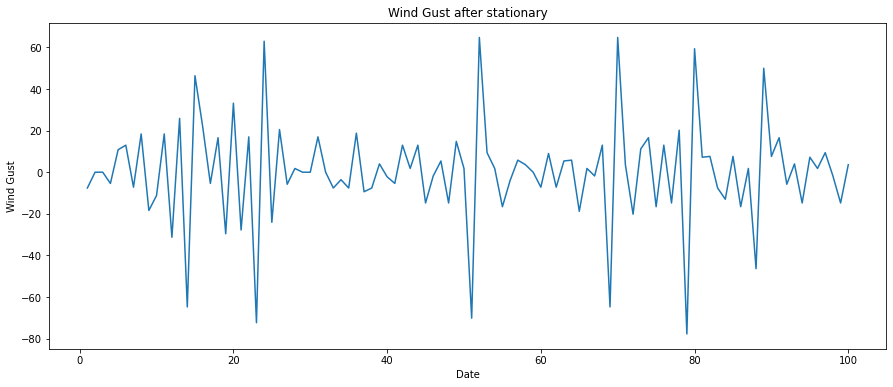

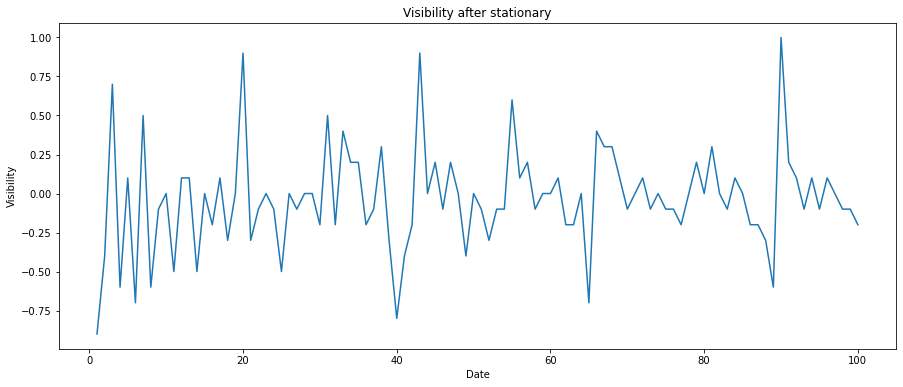

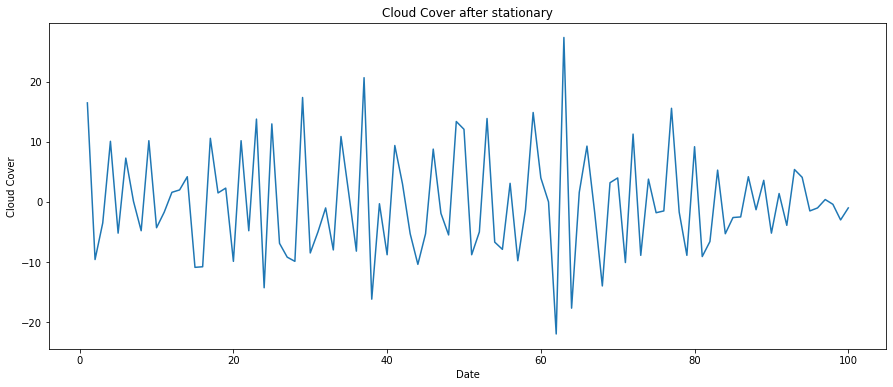

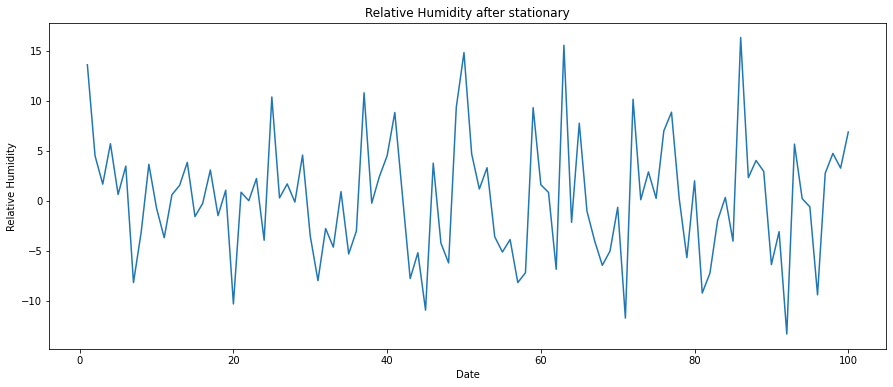

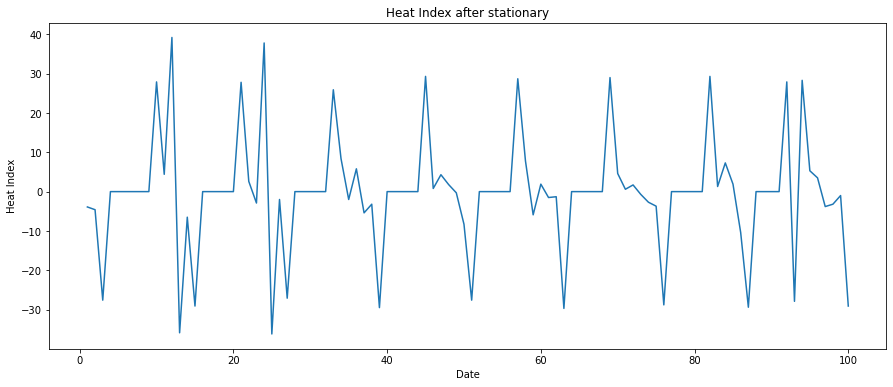

In [22]:
for feature in train_diff:
    train_diff[str(feature)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)} after stationary")
    plt.show()

In [23]:
cointegration_test(train_diff)

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Solar  >  1756.12   > nan       =>   False
Hydro  >  1334.65   > 311.1288  =>   True
Wind   >  1044.14   > 263.2603  =>   True
Temperature >  773.17    > 219.4051  =>   True
Wind Chill >  545.28    > 179.5199  =>   True
Precipitation >  385.01    > 143.6691  =>   True
Wind Speed >  258.1     > 111.7797  =>   True
Wind Direction >  177.28    > 83.9383   =>   True
Wind Gust >  111.95    > 60.0627   =>   True
Visibility >  76.36     > 40.1749   =>   True
Cloud Cover >  45.02     > 24.2761   =>   True
Relative Humidity >  22.56     > 12.3212   =>   True
Heat Index >  4.5       > 4.1296    =>   True


In [30]:
param_grid = {'p': [1,2], 'q':[1,2], 'tr': ['n']}
pg = list(ParameterGrid(param_grid))
pg

[{'p': 1, 'q': 1, 'tr': 'n'},
 {'p': 1, 'q': 2, 'tr': 'n'},
 {'p': 2, 'q': 1, 'tr': 'n'},
 {'p': 2, 'q': 2, 'tr': 'n'}]

In [31]:
from scipy import linalg
df_results_VARMA = pd.DataFrame(columns=['p', 'q', 'tr','RMSE Solar','RMSE Hydro','RMSE Wind'])

for a,b in enumerate(pg):
    print("iteration")
    p = b.get('p')
    q = b.get('q')
    tr = b.get('tr')
    model = VARMAX(train_diff, order=(p,q), trend=tr,enforce_stationarity=False).fit(disp=0)
    z = model.forecast(y=train_diff[['Solar',  'Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Visibility','Cloud Cover','Relative Humidity','Heat Index']].values, steps=len(testX))
    df_pred = pd.DataFrame(z, columns=[ 'Solar', 'Hydro', 'Wind' ])
    res = inverse_diff(df[['Solar','Hydro', 'Wind' ]],df_pred)
    openrmse = np.sqrt(metrics.mean_squared_error(testX.Solar, res.Solar_1st_inv_diff))
#     highrmse = np.sqrt(metrics.mean_squared_error(testX.Biomass_Energy_Production, res.Biomass_Energy_Production_1st_inv_diff))
    lowrmse = np.sqrt(metrics.mean_squared_error(testX.Hydro, res.Hydro_1st_inv_diff))
#     closermse = np.sqrt(metrics.mean_squared_error(testX.Geothermal_Energy_Production, res.Geothermal_Energy_Production_1st_inv_diff))
    windrmse = np.sqrt(metrics.mean_squared_error(testX.Wind, res.Wind_1st_inv_diff))
    df_results_VARMA = df_results_VARMA.append({'p': p, 'q': q, 'tr': tr,'RMSE Solar': openrmse,
                                                'RMSE Hydro':lowrmse,
                                                 'RMSE Wind' : windrmse}, ignore_index=True)

iteration
iteration
iteration
iteration


In [44]:
df_result=df_results_VARMA.sort_values(by=['RMSE Solar','RMSE Hydro','RMSE Wind']).head(2)



In [46]:
best_values_VARMA = df_result.tail(1)
best_values_VARMA

,p,q,tr,RMSE Solar,RMSE Hydro,RMSE Wind
3,2,2,n,0.004753,0.001032,0.001976


In [47]:
p_value_VARMA = best_values_VARMA['p'].iloc[0]
q_value_VARMA = best_values_VARMA['q'].iloc[0] 
tr_value_VARMA = best_values_VARMA['tr'].iloc[0]

In [48]:
model = VARMAX(train_diff,order=(p_value_VARMA, q_value_VARMA),trends = tr_value_VARMA,enforce_stationarity=False).fit(disp=0)
result = model.forecast(steps = 500)


In [49]:
res = inverse_diff(final_prod[['Solar', 'Hydro','Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Visibility','Cloud Cover','Relative Humidity','Heat Index']], result)
print(len(res))
res.tail()

500


,Solar,Hydro,Wind,Temperature,Wind Chill,Precipitation,Wind Speed,Wind Direction,Wind Gust,Visibility,...,Wind_1st_inv_diff,Temperature_1st_inv_diff,Wind Chill_1st_inv_diff,Precipitation_1st_inv_diff,Wind Speed_1st_inv_diff,Wind Direction_1st_inv_diff,Visibility_1st_inv_diff,Cloud Cover_1st_inv_diff,Relative Humidity_1st_inv_diff,Heat Index_1st_inv_diff
595,0.000044,0.000011,0.000039,-0.137,-0.09,-0.0121,0.015,0.4244,0.036,-0.035,...,0.026804,-51.514899,-46.365797,141.326836,34.180944,310.911619,-7.721873,-38.785302,173.535206,-167.409536
596,0.000044,0.000011,0.000039,-0.137,-0.09,-0.0121,0.015,0.4244,0.036,-0.035,...,0.026843,-51.651899,-46.455797,141.314736,34.195944,311.336019,-7.756873,-38.936302,173.741906,-167.770536
597,0.000044,0.000011,0.000039,-0.137,-0.09,-0.0121,0.015,0.4244,0.036,-0.035,...,0.026882,-51.788899,-46.545797,141.302636,34.210944,311.760419,-7.791873,-39.087302,173.948606,-168.131536
598,0.000044,0.000011,0.000039,-0.137,-0.09,-0.0121,0.015,0.4244,0.036,-0.035,...,0.026921,-51.925899,-46.635797,141.290536,34.225944,312.184819,-7.826873,-39.238302,174.155306,-168.492536
599,0.000044,0.000011,0.000039,-0.137,-0.09,-0.0121,0.015,0.4244,0.036,-0.035,...,0.026960,-52.062899,-46.725797,141.278436,34.240944,312.609219,-7.861873,-39.389302,174.362006,-168.853536


In [50]:
print(len(testX))

44


In [51]:
test_test=res[:44]
pred_test=res[45:]
for i in ['Solar', 'Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Visibility','Cloud Cover','Relative Humidity','Heat Index']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(testX[str(i)] , test_test[str(i)+'_1st_inv_diff'])
    

Evaluation metric for Solar
MSE is : 2.3623343452982834e-05
MAE is : 0.004239477146403585
RMSE is : 0.004860385113649209
MAPE is : 101.98352098553771
R2 is : -2.2997294422789016

Evaluation metric for Hydro
MSE is : 2.157132600380717e-06
MAE is : 0.0012491303657686356
RMSE is : 0.0014687180125472407
MAPE is : 32.3478073427518
R2 is : -1.2088970905253729

Evaluation metric for Wind
MSE is : 5.651166851135983e-06
MAE is : 0.0021836071400068097
RMSE is : 0.0023772183011107717
MAPE is : 41.59749060169846
R2 is : -1.8736295799971052

Evaluation metric for Temperature
MSE is : 33.2414607259894
MAE is : 5.035451061801627
RMSE is : 5.765540800826007
MAPE is : 49.522563276568796
R2 is : -0.08706797939620392

Evaluation metric for Wind Chill
MSE is : 29.6311627525636
MAE is : 4.56503951607359
RMSE is : 5.443451364030325
MAPE is : inf
R2 is : -0.2262889311068983

Evaluation metric for Precipitation
MSE is : 10515.434618469879
MAE is : 94.4653981844706
RMSE is : 102.54479322944621
MAPE is : 707.84

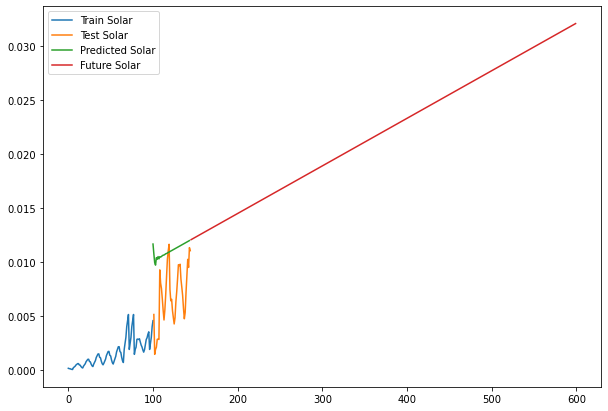

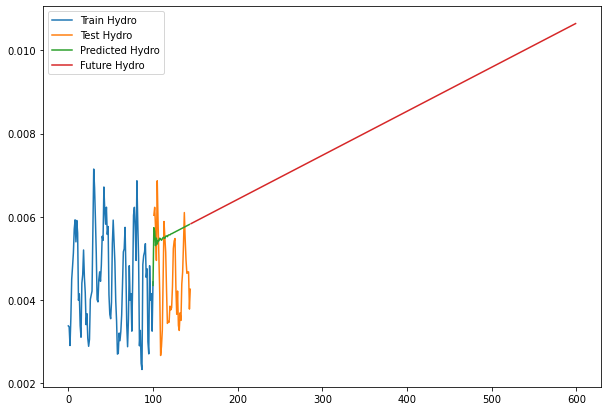

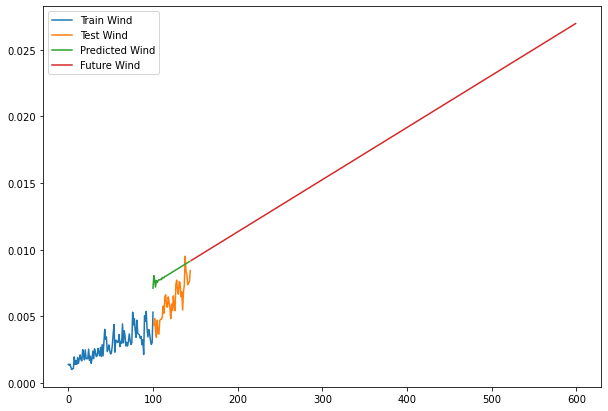

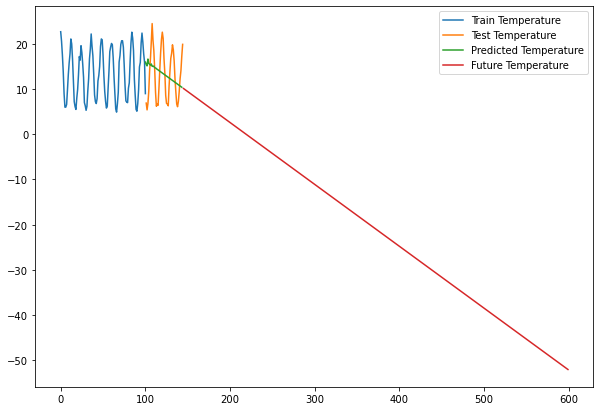

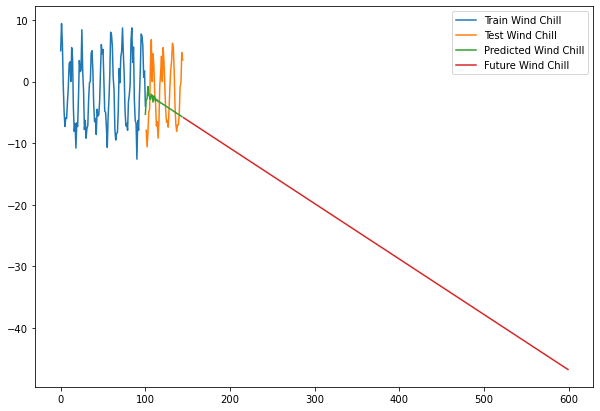

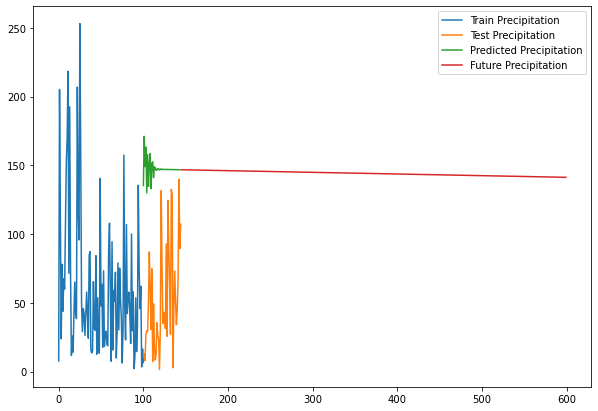

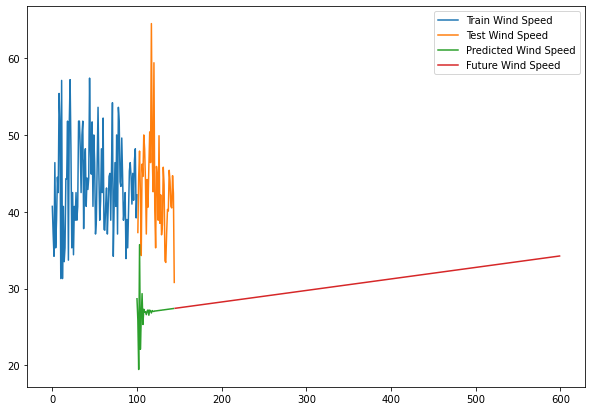

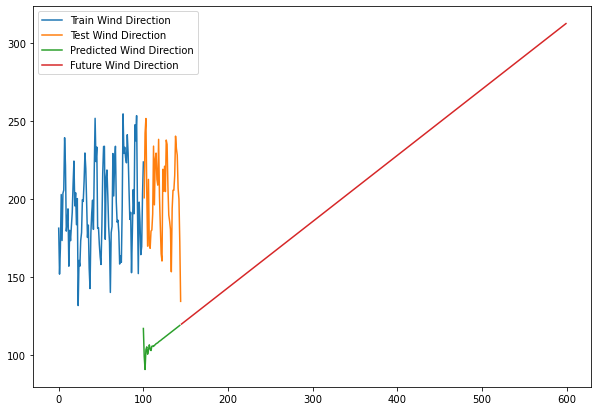

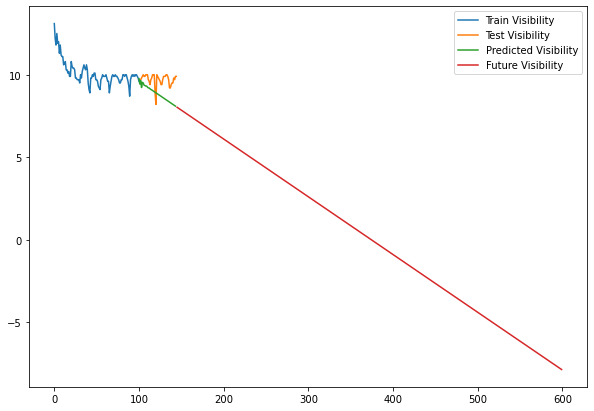

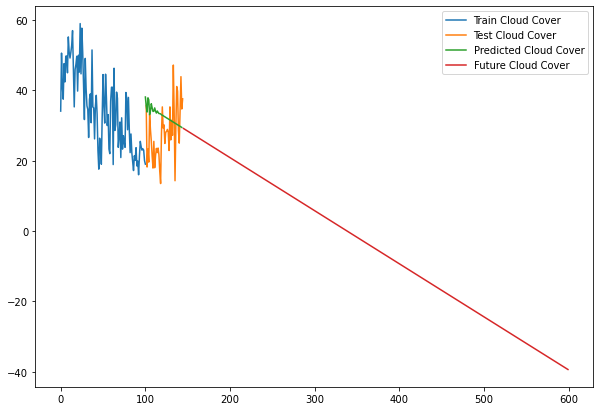

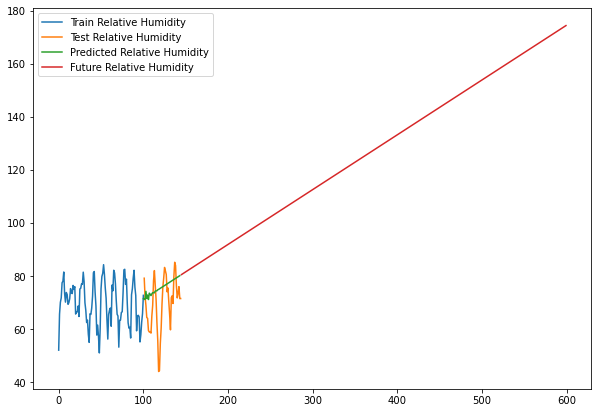

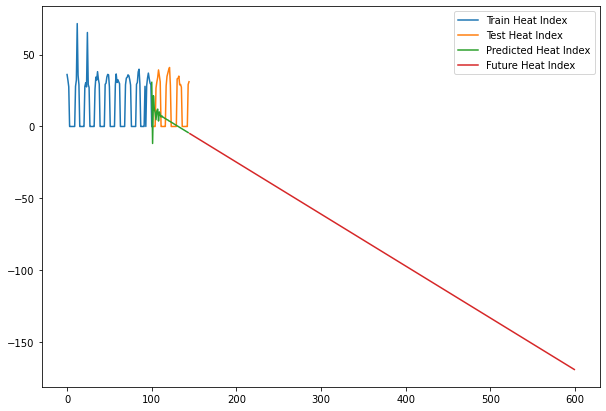

In [52]:
for i in ['Solar', 'Hydro', 'Wind','Temperature','Wind Chill','Precipitation','Wind Speed','Wind Direction','Visibility','Cloud Cover','Relative Humidity','Heat Index']:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(trainX[str(i)], label='Train '+str(i))
    plt.plot(testX[str(i)], label='Test '+str(i))
    plt.plot(test_test[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.plot(pred_test[str(i)+'_1st_inv_diff'], label='Future '+str(i))
    plt.legend(loc='best')
    plt.show()

In [53]:
pred_test["Total Renewables (Geo, Solar, Wind, Other)"]=pred_test['Solar_1st_inv_diff']+ pred_test['Hydro_1st_inv_diff']+pred_test['Wind_1st_inv_diff']
pred_test.head()




,Solar,Hydro,Wind,Temperature,Wind Chill,Precipitation,Wind Speed,Wind Direction,Wind Gust,Visibility,...,Temperature_1st_inv_diff,Wind Chill_1st_inv_diff,Precipitation_1st_inv_diff,Wind Speed_1st_inv_diff,Wind Direction_1st_inv_diff,Visibility_1st_inv_diff,Cloud Cover_1st_inv_diff,Relative Humidity_1st_inv_diff,Heat Index_1st_inv_diff,"Total Renewables (Geo, Solar, Wind, Other)"
145,0.000044,0.000011,0.000039,-0.136990,-0.090001,-0.012134,0.015131,0.424440,0.036776,-0.035000,...,10.135108,-5.865825,146.771594,27.431027,119.931664,8.028128,29.164679,80.520183,-4.959509,0.027109
146,0.000044,0.000011,0.000039,-0.137010,-0.089930,-0.011598,0.014876,0.424328,0.035239,-0.035001,...,9.998098,-5.955755,146.759995,27.445903,120.355991,7.993127,29.013676,80.726901,-5.320533,0.027203
147,0.000044,0.000011,0.000039,-0.136996,-0.090059,-0.012438,0.015022,0.424418,0.036218,-0.034999,...,9.861101,-6.045814,146.747557,27.460925,120.780409,7.958128,28.862722,80.933625,-5.681556,0.027296
148,0.000044,0.000011,0.000039,-0.136999,-0.089993,-0.012072,0.015063,0.424426,0.036276,-0.035000,...,9.724102,-6.135807,146.735484,27.475988,121.204835,7.923127,28.711691,81.140291,-6.042530,0.027390
149,0.000044,0.000011,0.000039,-0.137002,-0.089969,-0.011993,0.014926,0.424378,0.035618,-0.035000,...,9.587100,-6.225776,146.723491,27.490914,121.629214,7.888127,28.560693,81.347010,-6.403513,0.027484


In [60]:
test_test["Total Renewables (Geo, Solar, Wind, Other)"]=test_test['Solar_1st_inv_diff']+ test_test['Hydro_1st_inv_diff']+test_test['Wind_1st_inv_diff']
# trainX['Total Renewable Energy Production']=df[]

test_tot=df.iloc[-44:]["Total Renewables (Geo, Solar, Wind, Other)"]

In [61]:
print(f'Evaluation metric for Total Renewable Energy Production using VARMA')
timeseries_evaluation_metrics_func(test_tot , test_test['Total Renewables (Geo, Solar, Wind, Other)'])
    

Evaluation metric for Total Renewable Energy Production using VARMA
MSE is : 4.3841785746713025e-05
MAE is : 0.006303388123048741
RMSE is : 0.006621312992655839
MAPE is : 36.109900740403255
R2 is : -4.7742087084481035



In [65]:
df[102:]

,"Coal, Peat and Manufactured Gases",Combustible Renewables,Geothermal,Hydro,Natural Gas,Not Specified,Nuclear,Oil and Petroleum Products,Other Combustible Non-Renewables,Other Renewables,Solar,Wind,Total Combustible Fuels,"Total Renewables (Geo, Solar, Wind, Other)"
Time,,,,,,,,,,,,,,
2018-07-01,0.045623,0.000937,0,0.006229,0.012731,0,0,0.002087,0,0,0.001457,0.004832,0.061377,0.015949
2018-08-01,0.046443,0.001035,0,0.005743,0.010664,0,0,0.000174,0,0,0.001913,0.003930,0.058316,0.017104
2018-09-01,0.041779,0.000972,0,0.004953,0.011415,0,0,0.000210,0,0,0.002119,0.003424,0.054376,0.014511
2018-10-01,0.038934,0.001044,0,0.006866,0.009675,0,0,0.000144,0,0,0.002849,0.004714,0.049797,0.013346
2018-11-01,0.040155,0.000949,0,0.005862,0.011735,0,0,0.000259,0,0,0.002877,0.003720,0.053098,0.014267
2018-12-01,0.044268,0.000949,0,0.005002,0.009940,0,0,0.000423,0,0,0.002834,0.003666,0.055581,0.015769
2019-01-01,0.045210,0.000942,0,0.004132,0.018333,0,0,0.000201,0,0,0.009283,0.004692,0.064686,0.019050
2019-02-01,0.039397,0.000844,0,0.002671,0.015341,0,0,0.000445,0,0,0.008059,0.004775,0.056026,0.016349
2019-03-01,0.042792,0.000922,0,0.002888,0.017067,0,0,0.000289,0,0,0.007548,0.004778,0.061070,0.016137


In [75]:
df1 =pd.DataFrame({ 'test_data':test_tot.values,'pred_test':test_test['Total Renewables (Geo, Solar, Wind, Other)'].values,
                   'date':pd.date_range('2018-05-01', periods=len(test_tot.values),freq='M')})
df2 =pd.DataFrame({ 'future_forecast':pred_test['Total Renewables (Geo, Solar, Wind, Other)'].values,
                   'date':pd.date_range('2022-02-28', periods=len(pred_test['Total Renewables (Geo, Solar, Wind, Other)'].values),freq='M')})
df2=df2.set_index('date')
df1=df1.set_index('date')
# df=df.set_index('Time')

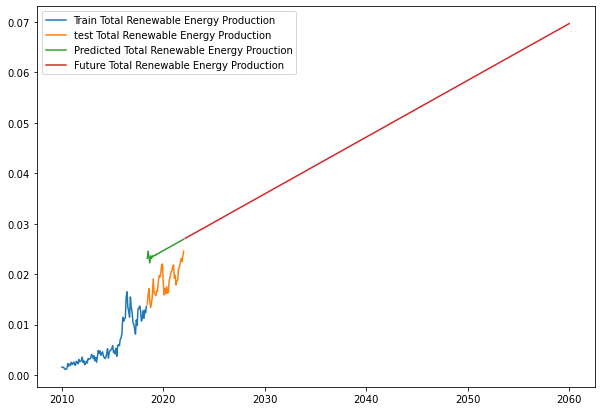

In [77]:
plt.plot(df.iloc[:-44]['Total Renewables (Geo, Solar, Wind, Other)'], label='Train Total Renewable Energy Production') 
plt.plot(df1['test_data'], label='test Total Renewable Energy Production')
plt.plot(df1['pred_test'], label='Predicted Total Renewable Energy Prouction')
plt.plot(df2['future_forecast'], label='Future Total Renewable Energy Production')
plt.legend(loc='best')
plt.show()